# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

In [61]:
# importing libraries
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score

## Load Data

In [62]:
import pandas as pd

# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [63]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [64]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

In [65]:
# shapes of the data
print(f'the shape of the whole data : {data.shape}')
print(f'the shape of train data : {X_train.shape}')
print(f'the shape of test data : {X_test.shape}')

the shape of the whole data : (18442, 9)
the shape of train data : (16597, 8)
the shape of test data : (1845, 8)


#### Observation : the data contines 18442 rows and 9 columns 

In [66]:
# describtion of the data
df.describe(include='all')

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
count,18442.000000,18442.000000,18442,18442,18442.000000,18442,18442,18442,18442.000000
unique,NaN,NaN,13142,18439,NaN,2,6,14,NaN
top,NaN,NaN,Love it!,I bought this shirt at the store and after goi...,NaN,General,Tops,Dresses,NaN
freq,NaN,NaN,129,2,NaN,11664,8713,5371,NaN
mean,954.896757,43.383635,NaN,NaN,2.697484,NaN,NaN,NaN,0.816235
std,141.571783,12.246264,NaN,NaN,5.942220,NaN,NaN,NaN,0.387303
min,2.000000,18.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,863.000000,34.000000,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000
50%,952.000000,41.000000,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000
75%,1078.000000,52.000000,NaN,NaN,3.000000,NaN,NaN,NaN,1.000000


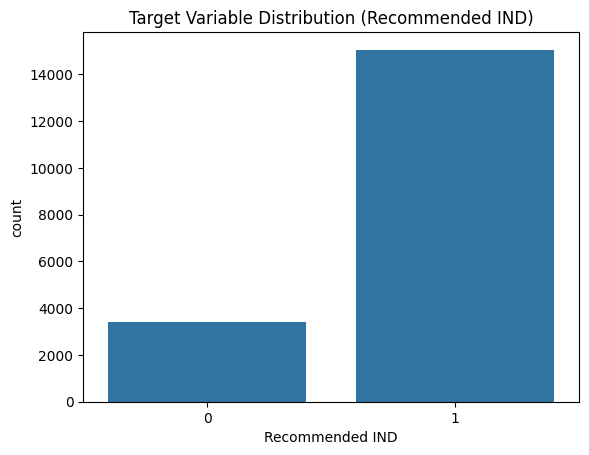

In [67]:
# Visualizing target distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Recommended IND', data=data)
plt.title("Target Variable Distribution (Recommended IND)")
plt.show()

### observation : as we see the accurance of 1 is more than 0 by far away 

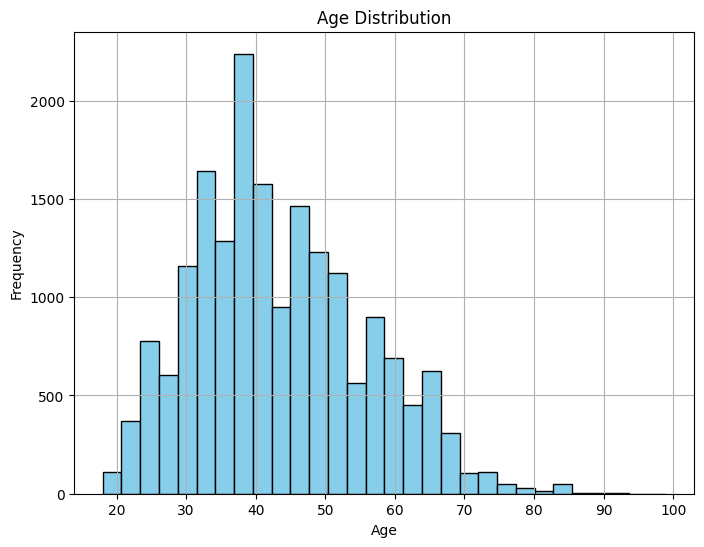

In [68]:
# Age distribution
plt.figure(figsize=(8, 6))
df['Age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


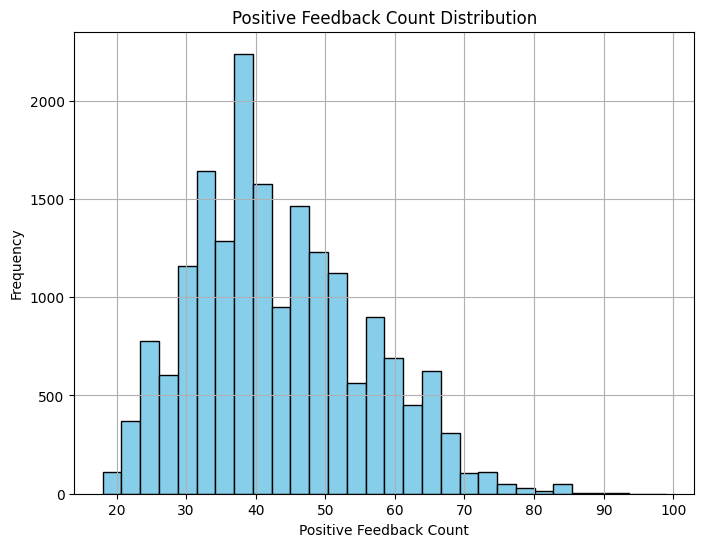

In [69]:
# Positive Feedback Count distribution
plt.figure(figsize=(8, 6))
df['Age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Positive Feedback Count Distribution')
plt.xlabel('Positive Feedback Count')
plt.ylabel('Frequency')
plt.show()

## Building Pipeline

In [70]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
nlp = spacy.load("en_core_web_sm")

In [71]:
# spliting data into numerical, categorical, and text features
num_features = X.select_dtypes(exclude='object').columns.drop(['Clothing ID'])
print('Numerical features:', num_features)

cat_features = X[['Division Name', 'Department Name','Class Name']].columns
print('Categorical features:', cat_features)

text_features = X[['Title','Review Text']].columns
print ('Review Text features:', text_features)

Numerical features: Index(['Age', 'Positive Feedback Count'], dtype='object')
Categorical features: Index(['Division Name', 'Department Name', 'Class Name'], dtype='object')
Review Text features: Index(['Title', 'Review Text'], dtype='object')


In [72]:
# Combine Title and Review Text into one feature for text processing
def merge_text_columns(df: pd.DataFrame) ->str:
    """
    Combining the 'Title' and 'Review Text' columns into a single text feature.
    """
    title = df['Title']
    review_text = df['Review Text']
    # Concatenate the title and review
    return title + " " + review_text

In [73]:

# Custom text preprocessor using spaCy for tokenization and lemmatization
def spacy_text_preprocessor(text:str) ->str :
    """
    conveting text to lowercase, tokenizing, and lemmatizing the text using spaCy.
    removing Punctuation and whitespace and removing non alpha character.
    """
    # Lowercase the text
    text = text.lower()
    # Process the text with spaCy
    doc = nlp(text)

    # returning lemmatized tokens Only keeping tokens that consist of alphabetic characters.
    return " ".join(token.lemma_ for token in doc if token.is_alpha)

In [74]:
# pipeline for numrical features 
num_pipeline = Pipeline([
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler())

])

In [75]:
# pipeline for catgorical features
cat_pipeline = Pipeline([
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('scaler',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))

])

In [76]:
# text feature pipeline : Combine columns and convert to TF-IDF
text_pipeline = Pipeline([
        ('combine', FunctionTransformer(merge_text_columns, validate=False)),
    ('tfidf', TfidfVectorizer(preprocessor=spacy_text_preprocessor, stop_words='english'))

])

In [77]:
# Combine all feature-specific pipelines into one ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('text', text_pipeline, text_features)
])

In [78]:
# Full pipeline with a classifier
full_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Ind...dtype='object')),
                                                 ('text',
                                                  Pipeline(steps=[('combine',
                                                                   FunctionTransformer(func=<function merge_text_columns at 0x000001E3D89BBA60>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(preprocessor=<function spacy_text_preprocessor at 0x000001E3D89BB7E0>,
                                                                                   stop_words='english'))]),
                                                  Index(['Title', 'Review Text'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Training Pipeline

In [80]:
# Fit the model pipeline to training data
full_pipeline.fit(X_train, y_train)
# Predict on the test set
y_pred = full_pipeline.predict(X_test)

c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


In [81]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')  
precision = precision_score(y_test, y_pred, average='binary') 

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

Accuracy: 0.86
Recall: 0.99
Precision: 0.86


## Fine-Tuning Pipeline

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [10, 20],
}

# Set up GridSearchCV with 3-folds cross-validation
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, verbose=3,scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 1/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=50;, score=0.815 total time= 3.1min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 2/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=50;, score=0.816 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 3/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=50;, score=0.815 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 1/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100;, score=0.815 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 2/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100;, score=0.816 total time= 2.9min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 3/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100;, score=0.815 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 1/3] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=50;, score=0.815 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 2/3] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=50;, score=0.816 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 3/3] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=50;, score=0.815 total time= 2.9min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


[CV 1/3] END classifier__max_depth=10, classifier__max_features=log2, classifier__n_estimators=100;, score=0.815 total time= 3.0min


c:\Users\amg11\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


In [ ]:
# Output the best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy: %.2f " % grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train,y_train)
y_pred_b = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_b)
recall = recall_score(y_test, y_pred_b, average='binary')  
precision = precision_score(y_test, y_pred_b, average='binary') 

# Print results
print(f"Accuracy for best model : {accuracy:.2f}")
print(f"Recall for best model : {recall:.2f}")
print(f"Precision for best model : {precision:.2f}")